In [ ]:
#Install Dependencies
!pip install gym==0.21.0 torch matplotlib pandas scikit-learn --quiet

In [30]:
#Install Dependencies
!pip install stable-baselines3[extra] gymnasium pandas scikit-learn matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 751.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 14.0 MB/s eta 0:00:00


In [33]:
!pip install shimmy>=2.0 --quiet

In [2]:
#Import Necessary Libraries
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
#Load the Data
df = pd.read_csv('/content/ad_bidding_dataset.csv')

In [7]:
#Visualize Dataset Structure

df.head()

,timestamp,day,hour,day_of_week,ad_type,website,user_segment,cost,base_ctr,adjusted_ctr,bid_amount,won_auction,impression_served,click_occurred,remaining_daily_budget
0,2023-01-01 00:00:00,0,0,6,banner,blog,seniors,4.30,0.1124,0.1176,0.00,0,0,0,100.00
1,2023-01-01 00:12:00,0,0,6,sidebar,gaming,students,1.74,0.1957,0.1855,1.91,1,1,0,98.26
2,2023-01-01 00:24:00,0,0,6,banner,social,tech_enthusiasts,1.34,0.1439,0.1321,1.48,0,0,0,98.26
3,2023-01-01 00:36:00,0,0,6,native,gaming,students,3.75,0.2053,0.2142,0.00,0,0,0,98.26
4,2023-01-01 00:48:00,0,0,6,popup,social,tech_enthusiasts,5.04,0.1005,0.1054,0.00,0,0,0,98.26


In [8]:
data = df.copy()

In [9]:
# 4) Dynamic Weighting to create a State Feature Vector

#Identify numeric & categorical features
numeric_feats = ['won_auction','impression_served','adjusted_ctr','base_ctr',
                 'click_occurred','remaining_daily_budget','cost','hour','day_of_week']
cat_feats     = ['website','ad_type','user_segment']

#Compute absolute Pearson correlations
corr_bid    = df[numeric_feats].corrwith(df['bid_amount']).abs()
corr_budget = df[numeric_feats].corrwith(df['remaining_daily_budget']).abs()

#Combine & normalize to sum=1
weights_numeric = (corr_bid + corr_budget)
weights_numeric /= weights_numeric.sum()

#Normalize numeric columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_feats] = scaler.fit_transform(df[numeric_feats])

#One‑hot encode categoricals (dummy template as in notebook)
df_cat = pd.get_dummies(df[cat_feats], drop_first=True)

#Assign equal small weight to each dummy (summing to 0.1 total)
total_cat_weight = 0.1
per_dummy_weight = total_cat_weight / df_cat.shape[1]
weights_cat = {col: per_dummy_weight for col in df_cat.columns}

#Merge scaled numerics & dummies
df_state = pd.concat([df_scaled[numeric_feats], df_cat], axis=1)

#Final weights dict (numeric + categorical)
state_weights = {**weights_numeric.to_dict(), **weights_cat}

#Build state vectors
def build_state_vec(row):
    return np.array([row[f] * state_weights[f] for f in df_state.columns], dtype=np.float32)

states = df_state.apply(build_state_vec, axis=1).tolist()

In [63]:
#CUSTOM GYM ENVIRONMENT
import numpy as np
import pandas as pd
import gym
from gym import spaces

class AdBiddingEnv(gym.Env):
    def __init__(self, states, df, max_budget=1000):
        super().__init__()
        self.states = states
        self.df = df.reset_index(drop=True)
        self.max_budget = max_budget
        self.n = len(df)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(states[0]),), dtype=np.float32
        )
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        # Track websites & per-site budgets
        self.websites = df['website'].unique().tolist()
        self.reset_website_budgets()
        self.total_clicks = 0  # Initialize total_clicks

    def reset_website_budgets(self):
        self.budget_by_site = {site: 0.0 for site in self.websites}

    def reset(self):
        self.i = 0
        self.budget = self.max_budget
        self.reset_website_budgets()
        self.total_clicks = 0  # Reset total_clicks on reset
        return self.states[0]

    def step(self, action):
        bid = action[0] * 10.0
        alloc = action[1] * self.budget

        row = self.df.iloc[self.i]
        site = row['website']
        click = row['click_occurred']
        won = row['won_auction']
        ctr = row['adjusted_ctr']
        cost = row['cost']

        # Track per-website allocation
        self.budget_by_site[site] += alloc

        # Reward: clicks + CTR + CVR bonus - overspend penalty
        reward = click * 5.0 + ctr * 2.0 + (click if won else 0.0) * 3.0
        if bid > cost:
            reward -= (bid - cost)
        if alloc > self.budget:
            reward -= 10.0

        self.budget -= alloc
        self.i += 1
        done = (self.i >= self.n) or (self.budget <= 0.0)
        next_state = self.states[self.i] if not done else np.zeros_like(self.states[0])

        # Increment total_clicks if click occurred
        self.total_clicks += click

        return next_state, reward, done, {}

In [44]:
#Custom GYM Environment
import numpy as np
import pandas as pd
import gym
from gym import spaces

class AdBiddingEnv(gym.Env):
    def __init__(self, states, df, max_budget=1000):
        super().__init__()
        self.states = states
        self.df = df.reset_index(drop=True)
        self.max_budget = max_budget
        self.n = len(df)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(states[0]),), dtype=np.float32
        )
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        # Track websites & per-site budgets
        self.websites = df['website'].unique().tolist()
        self.reset_website_budgets()
        self.total_clicks = 0  # Initialize total_clicks
        # Define bid_values as an attribute of the environment
        self.bid_values = np.linspace(0, 10, num=100) # Example: 100 bid values from 0 to 10


    def reset_website_budgets(self):
        self.budget_by_site = {site: 0.0 for site in self.websites}

    def reset(self):
        self.i = 0
        self.budget = self.max_budget
        self.reset_website_budgets()
        self.total_clicks = 0  # Reset total_clicks on reset
        return self.states[0]

    def step(self, action):
        # Access bid_values using action as an index
        bid = self.bid_values[int(action[0] * (len(self.bid_values) - 1))] # Scale action to bid_values index
        alloc = action[1] * self.budget

        row = self.df.iloc[self.i]
        site = row['website']
        click = row['click_occurred']
        won = row['won_auction']
        ctr = row['adjusted_ctr']
        cost = row['cost']

        # Track per-website allocation
        self.budget_by_site[site] += alloc

        # Reward: clicks + CTR + CVR bonus - overspend penalty
        reward = click * 5.0 + ctr * 2.0 + (click if won else 0.0) * 3.0
        if bid > cost:
            reward -= (bid - cost)
        if alloc > self.budget:
            reward -= 10.0

        self.budget -= alloc
        self.i += 1
        done = (self.i >= self.n) or (self.budget <= 0.0)
        next_state = self.states[self.i] if not done else np.zeros_like(self.states[0])

        # Increment total_clicks if click occurred
        self.total_clicks += click

        return next_state, reward, done, {}

In [60]:
class AdBiddingEnv(gym.Env):
    """
    Custom Gym environment for ad bidding per website.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, states, df):
        super(AdBiddingEnv, self).__init__()

        # Example bid levels (discrete actions)
        self.bids = [0.10, 0.20, 0.50, 1.00]
        # Expose them for evaluation
        self.bid_values = self.bids

        # Action space: choose one of the discrete bid levels
        self.action_space = spaces.Discrete(len(self.bids))

        # Observation space: e.g., "states" could be a vector of features
        # Adjust low/high dims to match your data
        obs_low  = np.min(states, axis=0)
        obs_high = np.max(states, axis=0)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Store the website-specific data
        self.df = df.reset_index(drop=True)
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        # Return initial observation (first row of features)
        return self.df.loc[self.current_step, states].values.astype(np.float32)

    def step(self, action):
        bid = self.bid_values[action]
        row = self.df.loc[self.current_step]

        # Example reward logic: click occurs if row['click']==1
        click = row['click']
        reward = bid if click == 1 else 0.0

        # Advance step
        self.current_step += 1
        done = self.current_step >= len(self.df)

        # Next observation
        if not done:
            obs = self.df.loc[self.current_step, states].values.astype(np.float32)
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.float32)

        info = {'step': self.current_step}
        return obs, reward, done, info

    def render(self, mode='human'):
        pass

In [51]:
class AdBiddingEnv(gym.Env):
    """
    Custom Gym environment for ad bidding per website.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, states, df):
        super(AdBiddingEnv, self).__init__()

        # Example bid levels (discrete actions)
        self.bids = [0.10, 0.20, 0.50, 1.00]
        # Expose them for evaluation
        self.bid_values = self.bids

        # Action space: choose one of the discrete bid levels
        self.action_space = spaces.Discrete(len(self.bids))

        # Observation space: e.g., "states" could be a vector of features
        # Adjust low/high dims to match your data
        obs_low  = np.min(states, axis=0)
        obs_high = np.max(states, axis=0)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Store the website-specific data
        self.df = df.reset_index(drop=True)
        self.current_step = 0
        # Store state feature names to access columns by name
        self.state_feature_names = df_state.columns

    def reset(self):
        self.current_step = 0
        # Return initial observation (first row of features)
        # Access columns using self.state_feature_names
        return self.df.loc[self.current_step, self.state_feature_names].values.astype(np.float32)

    def step(self, action):
        bid = self.bid_values[action]
        row = self.df.loc[self.current_step]

        # Example reward logic: click occurs if row['click']==1
        click = row['click_occurred']  # Changed 'click' to 'click_occurred'
        reward = bid if click == 1 else 0.0

        # Advance step
        self.current_step += 1
        done = self.current_step >= len(self.df)

        # Next observation
        if not done:
            obs = self.df.loc[self.current_step, self.state_feature_names].values.astype(np.float32)
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.float32)

        info = {'step': self.current_step}
        return obs, reward, done, info

    def render(self, mode='human'):
        pass

In [61]:
# Instantiate environment
env = AdBiddingEnv(states, df)

In [12]:
#PPO Implementation
class Actor(nn.Module):
    def __init__(self, dim_s, dim_a):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_s, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, dim_a), nn.Sigmoid()
        )
        self.logstd = nn.Parameter(torch.zeros(dim_a))

    def forward(self, x):
        mu = self.net(x)
        std = torch.exp(self.logstd)
        return mu, std

class Critic(nn.Module):
    def __init__(self, dim_s):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_s, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
# Hyperparameters
EPOCHS = 4
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPS_CLIP = 0.2
LR = 3e-4
EPISODES = 200

dim_s = env.observation_space.shape[0]
dim_a = env.action_space.shape[0]


In [14]:
actor = Actor(dim_s, dim_a)
critic = Critic(dim_s)
opt_a = optim.Adam(actor.parameters(), lr=LR)
opt_c = optim.Adam(critic.parameters(), lr=LR)

In [15]:
def select_action(state):
    s = torch.from_numpy(state).float()
    mu, std = actor(s)
    dist = Normal(mu, std)
    a = dist.sample()
    return a.clamp(0,1).detach().numpy(), dist.log_prob(a).sum()


In [16]:
def compute_gae(rewards, values, next_value, dones):
    values = values + [next_value]
    gae = 0.0
    advs = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + GAMMA * values[i+1] * (1 - dones[i]) - values[i]
        gae = delta + GAMMA * GAE_LAMBDA * gae * (1 - dones[i])
        advs.insert(0, gae)
    return advs

In [21]:
#Training Loop with Aggregate Losses

all_clicks     = []
all_site_allocs= []

for ep in range(EPISODES):
    state = env.reset()
    logps, rews, vals, dones = [], [], [], []
    clicks = 0

    #Collect one episode
    while True:
        # Keep the value as a tensor to preserve gradient history
        val = critic(torch.from_numpy(state).float())
        a, logp = select_action(state)
        next_state, reward, done, _ = env.step(a)

        clicks += int(df.iloc[env.i-1]['click_occurred'])
        logps.append(logp)
        rews.append(reward)
        # Store the tensor value instead of the detached item
        vals.append(val)
        dones.append(done)

        state = next_state
        if done:
            # Keep next_val as a tensor
            next_val = critic(torch.from_numpy(state).float())
            all_clicks.append(clicks)
            all_site_allocs.append(env.budget_by_site.copy())
            break

    #Compute advantages
    advs = compute_gae(rews, [v.item() for v in vals], next_val.item(), dones)
    advs_tensor = torch.tensor(advs, dtype=torch.float32)
    # vals should be a tensor of tensors, not a tensor of values
    # vals_tensor = torch.tensor(vals, dtype=torch.float32)
    vals_tensor = torch.stack(vals) # Stack the tensors
    rews_tensor = torch.tensor(rews, dtype=torch.float32)

    #Actor update (single backward)
    actor_losses = []
    for logp, adv in zip(logps, advs_tensor):
        ratio = torch.exp(logp - logp.detach())
        surr1 = ratio * adv
        surr2 = torch.clamp(ratio, 1-EPS_CLIP, 1+EPS_CLIP) * adv
        actor_losses.append(-torch.min(surr1, surr2))

    loss_a = torch.stack(actor_losses).mean()
    opt_a.zero_grad()
    loss_a.backward()
    opt_a.step()

    # Critic update (single backward)
    # Build next_values tensor
    next_vals = torch.cat([vals_tensor[1:], next_val.unsqueeze(0)])
    critic_losses = []
    for r, v, nv in zip(rews_tensor, vals_tensor, next_vals):
        critic_losses.append((r + GAMMA * nv - v) ** 2)

    loss_c = torch.stack(critic_losses).mean()
    opt_c.zero_grad()
    loss_c.backward()
    opt_c.step()

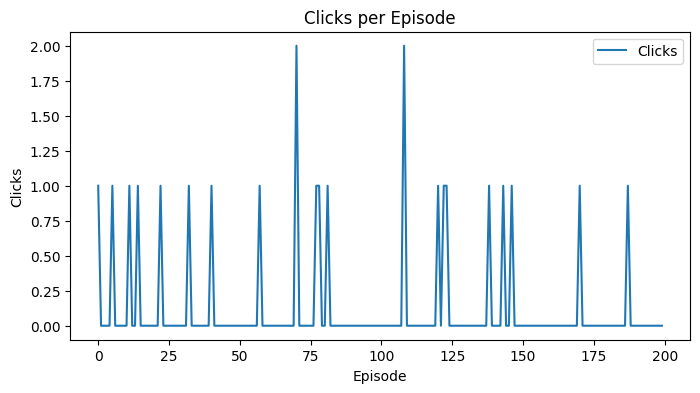

In [22]:
#Plot Clicks Per Episode
plt.figure(figsize=(8,4))
plt.plot(all_clicks, label='Clicks')
plt.title("Clicks per Episode")
plt.xlabel("Episode")
plt.ylabel("Clicks")
plt.legend()
plt.show()

In [36]:
from stable_baselines3 import PPO

# Train PPO on Each Website

from sklearn.preprocessing import LabelEncoder
# Assuming 'website', 'ad_type', 'user_segment' are categorical columns
cat_feats = ['website', 'ad_type', 'user_segment']
label_encoders = {}

for col in cat_feats:
    le = LabelEncoder()
    # Fit on your data
    le.fit(df[col])
    label_encoders[col] = le

website_labels = label_encoders['website'].classes_
clicks_per_website = {}

website_labels = label_encoders['website'].classes_
clicks_per_website = {}

for website_id, website_name in enumerate(website_labels):
    print(f"\nTraining PPO for Website: {website_name} (ID: {website_id})")

    # Filter the DataFrame for the current website
    website_df = df[df['website'] == website_name]

    # Now use the filtered DataFrame to create the environment
    env = AdBiddingEnv(states, website_df)
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=50000)

    # Evaluation

    obs = env.reset()
    done = False
    clicks = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
    clicks_per_website[website_name] = env.total_clicks
    avg_bid = round(np.mean(bid_history), 2)
    most_common_bid = Counter(bid_history).most_common(1)[0]

    optimal_bids[website_name] = {
        "Average_Bid": avg_bid,
        "Most_Frequent_Bid": most_common_bid[0],
        "Frequency": most_common_bid[1],
    }

    print(f"Total Clicks: {env.total_clicks}")


Training PPO for Website: blog (ID: 0)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Clicks: 5

Training PPO for Website: entertainment (ID: 1)
Total Clicks: 5

Training PPO for Website: gaming (ID: 2)
Total Clicks: 3

Training PPO for Website: news (ID: 3)
Total Clicks: 3

Training PPO for Website: shopping (ID: 4)
Total Clicks: 18

Training PPO for Website: social (ID: 5)
Total Clicks: 0


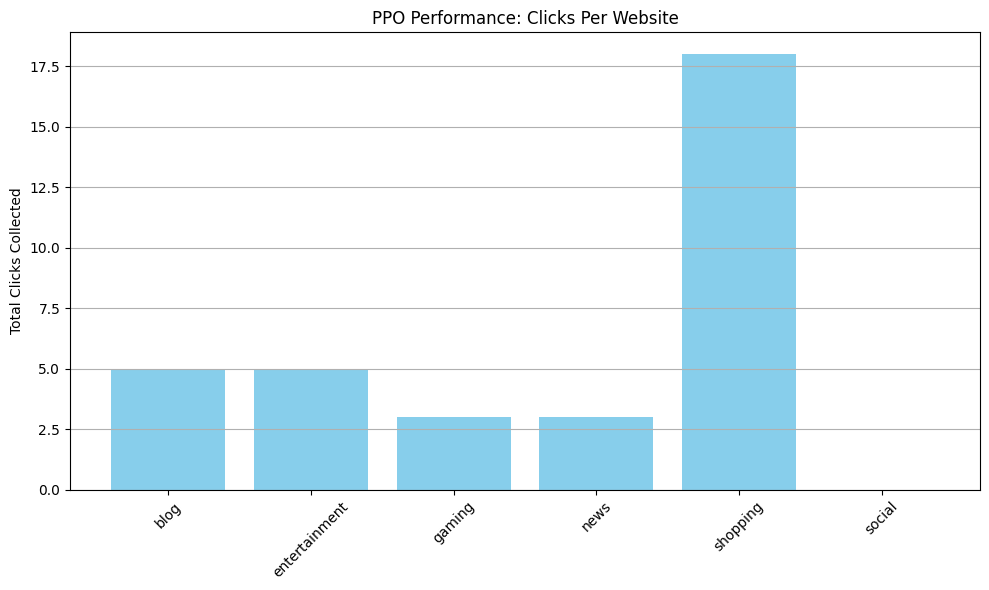

In [37]:
# Plot Clicks Per Website

plt.figure(figsize=(10,6))
plt.bar(clicks_per_website.keys(), clicks_per_website.values(), color='skyblue')
plt.ylabel("Total Clicks Collected")
plt.title("PPO Performance: Clicks Per Website")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [40]:
# User-defined total budget
user_budget = float(input("Enter your total advertising budget (e.g., 1000): "))

Enter your total advertising budget (e.g., 1000): 500


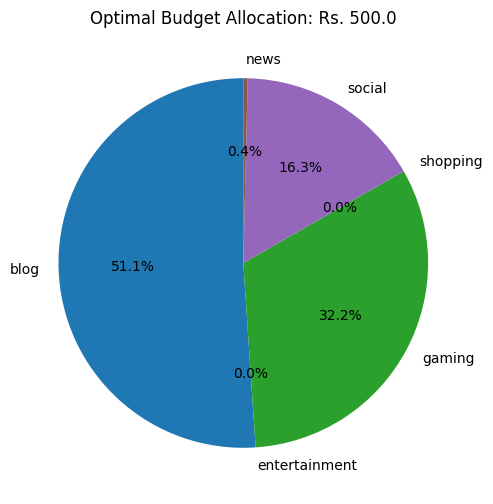

In [65]:
#Compute and Plot Optimal Budget Allocation
N = 50
last_allocs = all_site_allocs[-N:]

# Get unique websites from the 'all_site_allocs' data
all_websites = []
for allocs in all_site_allocs:
    all_websites.extend(allocs.keys())
unique_websites = list(set(all_websites))

avg_alloc = {
    site: np.mean([allocs.get(site, 0) for allocs in last_allocs])
    for site in unique_websites  # Use unique_websites here
}

labels = list(avg_alloc.keys())
sizes  = list(avg_alloc.values())

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f"Optimal Budget Allocation: Rs. {user_budget}")
plt.show()